In [1]:
import os
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import nibabel
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
import cv2
from skimage.filters import unsharp_mask
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from skimage.transform import resize
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.metrics import CCMetric
from dipy.align.imaffine import AffineMap
from dipy.align import resample

/home/uiu/miniconda3/envs/tf_conda/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-06 17:19:44.092248: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

1 Physical GPUs, 1 Logical GPUs


2024-04-06 17:19:46.807396: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-04-06 17:19:46.808038: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-04-06 17:19:46.864986: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-06 17:19:46.865192: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA TITAN Xp computeCapability: 6.1
coreClock: 1.582GHz coreCount: 30 deviceMemorySize: 11.90GiB deviceMemoryBandwidth: 510.07GiB/s
2024-04-06 17:19:46.865231: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-04-06 17:19:46.867562: I tensorflow/stream_executor/platform/default/d

# Model Structure

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
import six
from math import ceil
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, Dense, Flatten
from tensorflow.keras.layers import Conv3D, AveragePooling3D, MaxPooling3D
from tensorflow.keras.layers import add
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K


def _bn_relu(input):
    """Helper to build a BN -> relu block (by @raghakot)."""
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)


def _conv_bn_relu3D(**conv_params):
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1e-4))

    def f(input):
        conv = Conv3D(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            kernel_initializer=kernel_initializer,
            padding=padding,
            kernel_regularizer=kernel_regularizer,
        )(input)
        return _bn_relu(conv)

    return f


def _bn_relu_conv3d(**conv_params):
    """Helper to build a  BN -> relu -> conv3d block."""
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv3D(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            kernel_initializer=kernel_initializer,
            padding=padding,
            kernel_regularizer=kernel_regularizer,
        )(activation)

    return f


def _shortcut3d(input, residual):
    """3D shortcut to match input and residual and merges them with "sum"."""
    stride_dim1 = ceil(input.shape[DIM1_AXIS] / residual.shape[DIM1_AXIS])
    stride_dim2 = ceil(input.shape[DIM2_AXIS] / residual.shape[DIM2_AXIS])
    stride_dim3 = ceil(input.shape[DIM3_AXIS] / residual.shape[DIM3_AXIS])
    equal_channels = residual.shape[CHANNEL_AXIS] == input.shape[CHANNEL_AXIS]

    shortcut = input
    if stride_dim1 > 1 or stride_dim2 > 1 or stride_dim3 > 1 or not equal_channels:
        shortcut = Conv3D(
            filters=residual.shape[CHANNEL_AXIS],
            kernel_size=(1, 1, 1),
            strides=(stride_dim1, stride_dim2, stride_dim3),
            kernel_initializer="he_normal",
            padding="valid",
            kernel_regularizer=l2(1e-4),
        )(input)
    return add([shortcut, residual])


def _residual_block3d(
    block_function, filters, kernel_regularizer, repetitions, is_first_layer=False
):
    def f(input):
        for i in range(repetitions):
            strides = (1, 1, 1)
            if i == 0 and not is_first_layer:
                strides = (2, 2, 2)
            input = block_function(
                filters=filters,
                strides=strides,
                kernel_regularizer=kernel_regularizer,
                is_first_block_of_first_layer=(is_first_layer and i == 0),
            )(input)
        return input

    return f


def basic_block(
    filters,
    strides=(1, 1, 1),
    kernel_regularizer=l2(1e-4),
    is_first_block_of_first_layer=False,
):
    """Basic 3 X 3 X 3 convolution blocks. Extended from raghakot's 2D impl."""

    def f(input):
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv3D(
                filters=filters,
                kernel_size=(3, 3, 3),
                strides=strides,
                padding="same",
                kernel_initializer="he_normal",
                kernel_regularizer=kernel_regularizer,
            )(input)
        else:
            conv1 = _bn_relu_conv3d(
                filters=filters,
                kernel_size=(3, 3, 3),
                strides=strides,
                kernel_regularizer=kernel_regularizer,
            )(input)

        residual = _bn_relu_conv3d(
            filters=filters,
            kernel_size=(3, 3, 3),
            kernel_regularizer=kernel_regularizer,
        )(conv1)
        return _shortcut3d(input, residual)

    return f


def bottleneck(
    filters,
    strides=(1, 1, 1),
    kernel_regularizer=l2(1e-4),
    is_first_block_of_first_layer=False,
):
    """Basic 3 X 3 X 3 convolution blocks. Extended from raghakot's 2D impl."""

    def f(input):
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv3D(
                filters=filters,
                kernel_size=(1, 1, 1),
                strides=strides,
                padding="same",
                kernel_initializer="he_normal",
                kernel_regularizer=kernel_regularizer,
            )(input)
        else:
            conv_1_1 = _bn_relu_conv3d(
                filters=filters,
                kernel_size=(1, 1, 1),
                strides=strides,
                kernel_regularizer=kernel_regularizer,
            )(input)

        conv_3_3 = _bn_relu_conv3d(
            filters=filters,
            kernel_size=(3, 3, 3),
            kernel_regularizer=kernel_regularizer,
        )(conv_1_1)
        residual = _bn_relu_conv3d(
            filters=filters * 4,
            kernel_size=(1, 1, 1),
            kernel_regularizer=kernel_regularizer,
        )(conv_3_3)

        return _shortcut3d(input, residual)

    return f


def _handle_data_format():
    global DIM1_AXIS
    global DIM2_AXIS
    global DIM3_AXIS
    global CHANNEL_AXIS
    if K.image_data_format() == "channels_last":
        DIM1_AXIS = 1
        DIM2_AXIS = 2
        DIM3_AXIS = 3
        CHANNEL_AXIS = 4
    else:
        CHANNEL_AXIS = 1
        DIM1_AXIS = 2
        DIM2_AXIS = 3
        DIM3_AXIS = 4


def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError("Invalid {}".format(identifier))
        return res
    return identifier


class Resnet3DBuilder(object):
    """ResNet3D."""

    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions, reg_factor):
        """Instantiate a vanilla ResNet3D keras model.

        # Arguments
            input_shape: Tuple of input shape in the format
            (conv_dim1, conv_dim2, conv_dim3, channels) if dim_ordering='tf'
            (filter, conv_dim1, conv_dim2, conv_dim3) if dim_ordering='th'
            num_outputs: The number of outputs at the final softmax layer
            block_fn: Unit block to use {'basic_block', 'bottlenack_block'}
            repetitions: Repetitions of unit blocks
        # Returns
            model: a 3D ResNet model that takes a 5D tensor (volumetric images
            in batch) as input and returns a 1D vector (prediction) as output.
        """
        _handle_data_format()
        if len(input_shape) != 4:
            raise ValueError(
                "Input shape should be a tuple "
                "(conv_dim1, conv_dim2, conv_dim3, channels) "
                "for tensorflow as backend or "
                "(channels, conv_dim1, conv_dim2, conv_dim3) "
                "for theano as backend"
            )

        block_fn = _get_block(block_fn)
        input = Input(shape=input_shape)
        # first conv
        conv1 = _conv_bn_relu3D(
            filters=64,
            kernel_size=(7, 7, 7),
            strides=(2, 2, 2),
            kernel_regularizer=l2(reg_factor),
        )(input)
        pool1 = MaxPooling3D(pool_size=(3, 3, 3), strides=(2, 2, 2), padding="same")(
            conv1
        )

        # repeat blocks
        block = pool1
        filters = 64
        for i, r in enumerate(repetitions):
            block = _residual_block3d(
                block_fn,
                filters=filters,
                kernel_regularizer=l2(reg_factor),
                repetitions=r,
                is_first_layer=(i == 0),
            )(block)
            filters *= 2

        # last activation
        block_output = _bn_relu(block)

        # average poll and classification
        pool2 = AveragePooling3D(
            pool_size=(
                block.shape[DIM1_AXIS],
                block.shape[DIM2_AXIS],
                block.shape[DIM3_AXIS],
            ),
            strides=(1, 1, 1),
        )(block_output)
        flatten1 = Flatten()(pool2)
        if num_outputs > 1:
            dense = Dense(
                units=num_outputs,
                kernel_initializer="he_normal",
                activation="softmax",
                kernel_regularizer=l2(reg_factor),
            )(flatten1)
        else:
            dense = Dense(
                units=num_outputs,
                kernel_initializer="he_normal",
                activation="sigmoid",
                kernel_regularizer=l2(reg_factor),
            )(flatten1)

        model = Model(inputs=input, outputs=dense)
        return model

    @staticmethod
    def build_resnet_18(input_shape, num_outputs, reg_factor=1e-4):
        """Build resnet 18."""
        return Resnet3DBuilder.build(
            input_shape, num_outputs, basic_block, [2, 2, 2, 2], reg_factor=reg_factor
        )

    @staticmethod
    def build_resnet_34(input_shape, num_outputs, reg_factor=1e-4):
        """Build resnet 34."""
        return Resnet3DBuilder.build(
            input_shape, num_outputs, basic_block, [3, 4, 6, 3], reg_factor=reg_factor
        )

    @staticmethod
    def build_resnet_50(input_shape, num_outputs, reg_factor=1e-4):
        """Build resnet 50."""
        return Resnet3DBuilder.build(
            input_shape, num_outputs, bottleneck, [3, 4, 6, 3], reg_factor=reg_factor
        )

    @staticmethod
    def build_resnet_101(input_shape, num_outputs, reg_factor=1e-4):
        """Build resnet 101."""
        return Resnet3DBuilder.build(
            input_shape, num_outputs, bottleneck, [3, 4, 23, 3], reg_factor=reg_factor
        )

    @staticmethod
    def build_resnet_152(input_shape, num_outputs, reg_factor=1e-4):
        """Build resnet 152."""
        return Resnet3DBuilder.build(
            input_shape, num_outputs, bottleneck, [3, 8, 36, 3], reg_factor=reg_factor
        )


In [4]:
def apply_mask(aseg_image, brain_image, labels = [17, 53, 2, 7, 41, 46]):
    brain_data = aseg_image.get_fdata()
    aseg_data = aseg_image.get_fdata()
    origin_data = brain_image.get_fdata()
    
    brain_mask = np.zeros_like(aseg_data)
    for label in labels:
        brain_mask += np.where((aseg_data == label), 1, 0)

#     segmented_brain_image = brain_data * brain_mask
#     segmented_brain_image = nibabel.Nifti1Image(segmented_brain_image, affine=None)
    new_image = origin_data * brain_mask
    
    return new_image

def enhance_slice(slice_data):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_slice = clahe.apply(slice_data.astype(np.uint8))

    return enhanced_slice

def enhance_image(img_data):
    enhanced_slices = []
    
    for slice_idx in range(img_data.shape[2]):
        slice_data = img_data[:, :, slice_idx]
        enhanced_slice = enhance_slice(slice_data)
        enhanced_slices.append(enhanced_slice)
    enhanced_volume = np.dstack(enhanced_slices)

    return enhanced_volume

def sharpen_image(image, strength=1.0):
    sharpened_image = unsharp_mask(image, radius=1, amount=strength)
    return sharpened_image

def apply_nonlinear_registration(moving_image, fixed_image):
    metric = CCMetric(3)

    sdr = SymmetricDiffeomorphicRegistration(metric, [10, 10, 10], step_length=0.25, ss_sigma_factor=1.5)

    mapping = sdr.optimize(fixed_image, moving_image)

    warped_moving_image = mapping.transform(moving_image)

    return warped_moving_image

def image_fixed(image_type, target_shape):
    aseg_image = nibabel.load('adni-1-5t-filtered-preprocessed-quickseg-dataset/AD/I65597.nii/mri/aparc.DKTatlas+aseg.deep.mgz')
    base_path = "adni-1-5t-filtered-preprocessed-quickseg-dataset/AD/I65597.nii/mri//orig.mgz"
    origin_image =  nibabel.load(base_path)
    
    if (image_type=='nonroi') :
        aseg_image = aseg_image.get_fdata()
        origin_image = origin_image.get_fdata()
        
        mask = np.where(asg_img != 0, 1, 0)
        image = origin_image * mask
        image = enhance_image(image)
        image = resize(image, target_shape, anti_aliasing=True)
        image = sharpen_image(image)
        
        return image
    
    elif (image_type == 'roi') :
        image = apply_mask(aseg_image, origin_image)
        image = resize(image, target_shape, anti_aliasing=True)
        image = sharpen_image(image)
        return image

In [5]:
from scipy.ndimage import rotate

def augment(image, rotation_range):
    rotation_angle = np.random.uniform(-rotation_range, rotation_range)
    rotated_image = rotate(image, rotation_angle, reshape=False)
    
    return rotated_image

def image_loader_roi(image_path, target_shape, type_dt=''):
    aseg_image = nibabel.load(image_path)
    base_path = "/".join(image_path.split('/')[:-1]) + "/orig.mgz"
    base_image =  nibabel.load(base_path)
    
    image = apply_mask(aseg_image, base_image)
    image = resize(image, target_shape, anti_aliasing=True)
    image = enhance_image(image)
    image = sharpen_image(image)
    
    if type_dt=='train':
        image = augment(image, 50)

    return image

def image_load_nonRoi(image_path, target_shape, type_dt=''):
    asg_img = nibabel.load(image_path).get_fdata()
    
    origin_path = "/".join(image_path.split('/')[:-1]) + "/orig.mgz"
    origin_image = nibabel.load(origin_path).get_fdata()
    mask = np.where(asg_img != 0, 1, 0)
    
    image = origin_image * mask
    image = resize(image, target_shape, anti_aliasing=True)
    image = enhance_image(image)
    image = sharpen_image(image)

    
    if type_dt=='train':
        image = augment(image, 50)
        
        
    return image
    
def data_generator(paths, labels, batch_size, target_shape, image_type, type_dt=''):
    while True:
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]
            batch_images = []
            
            if image_type == 'roi':
                batch_images = [image_loader_roi(image, target_shape, type_dt) for image in batch_paths]
            elif image_type == 'nonroi':
                batch_images = [image_load_nonRoi(image, target_shape, type_dt) for image in batch_paths]

            batch_images = np.stack([batch_images] * 1, axis=-1)

            batch_labels = to_categorical(batch_labels, num_classes=2)
            yield np.array(batch_images), batch_labels

In [6]:
base_dir = 'adni-1-5t-filtered-preprocessed-quickseg-dataset'
ad = os.path.join(base_dir, 'AD')
mci = os.path.join(base_dir, 'MCI')
cn = os.path.join(base_dir, 'CN')

In [7]:
# original shape (257, 257, 257)

ad_images= []
mci_images = []
cn_images = []

for subject_dir in os.listdir(ad):
    mri_path = os.path.join(ad, subject_dir, 'mri', 'aparc.DKTatlas+aseg.deep.mgz')
    if not (len(os.listdir(os.path.join(ad, subject_dir, 'mri'))) < 6):
        ad_images.append(mri_path)
        
for subject_dir in os.listdir(mci):
    mri_path = os.path.join(mci, subject_dir, 'mri', 'aparc.DKTatlas+aseg.deep.mgz')
    
    if not (len(os.listdir(os.path.join(mci, subject_dir, 'mri'))) < 6):
        mci_images.append(mri_path)
        
for subject_dir in os.listdir(cn):
    mri_path = os.path.join(cn, subject_dir, 'mri', 'aparc.DKTatlas+aseg.deep.mgz')
    if not (len(os.listdir(os.path.join(cn, subject_dir, 'mri'))) < 6):
        cn_images.append(mri_path)

In [8]:
os.listdir('/'.join(ad_images[0].split('/')[:-1]))

['aparc.DKTatlas+aseg.deep.mgz',
 'mask.mgz',
 'orig.mgz',
 'orig',
 'orig_nu.mgz',
 'aseg.auto_noCCseg.mgz']

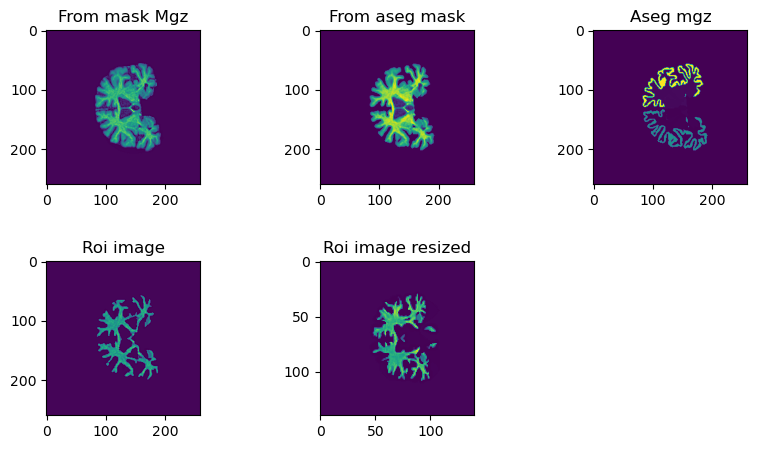

In [9]:
im1 = nibabel.load('adni-1-5t-filtered-preprocessed-quickseg-dataset/AD/I65597.nii/mri/orig.mgz')
asg_img = nibabel.load('adni-1-5t-filtered-preprocessed-quickseg-dataset/AD/I65597.nii/mri/aparc.DKTatlas+aseg.deep.mgz')
mask_mgz = nibabel.load('adni-1-5t-filtered-preprocessed-quickseg-dataset/AD/I65597.nii/mri/mask.mgz')

# ss = apply_mask(seg_img, im1)
mask = np.where(asg_img.get_fdata() != 0, 1, 0)
ss = im1.get_fdata() * mask
s_ss = enhance_image(ss)

mask_ss = im1.get_fdata() * mask_mgz.get_fdata()
mask_ss = enhance_image(mask_ss)
mask_ss = sharpen_image(mask_ss)

# ss = sharpen_image(ss)
# ss = resize(ss, (100, 100, 100), anti_aliasing=True)

# e_ss = resize(e_ss, (100, 100, 100), anti_aliasing=True)

# s_ss = sharpen_image(s_ss)
# ss = resize(ss, (100, 100, 100), anti_aliasing=True)

roi_image = apply_mask(asg_img, im1)
image = resize(roi_image, (140, 140, 140), anti_aliasing=True)


roi_image = enhance_image(roi_image)
roi_image = sharpen_image(roi_image)


image = enhance_image(image)
image = sharpen_image(image)


plt.figure(figsize=(10,5))

plt.subplot(2, 3, 1)
plt.imshow(mask_ss[:,:,140])
plt.title("From mask Mgz")

plt.subplot(2, 3, 2)
plt.imshow(s_ss[:,:,140])
plt.title("From aseg mask")

plt.subplot(2, 3, 3)
plt.imshow(asg_img.get_fdata()[:,:,140])
plt.title("Aseg mgz")

plt.subplot(2, 3, 4)
plt.imshow(roi_image[:, :, 140])
plt.title("Roi image")

plt.subplot(2, 3, 5)
plt.imshow(image[:, :, 65])
plt.title("Roi image resized")


plt.subplots_adjust(hspace=0.5)
plt.show()

In [10]:
# image_path = ad_images + mci_images + cn_images
# labels = [0] * len(ad_images) + [1] * len(mci_images) + [2] * len(cn_images)

# image_path = ad_images + mci_images
# labels = [0] * len(ad_images) + [1] * len(mci_images)

image_path = mci_images + cn_images + cn_images[:len(mci_images)-len(cn_images)]
labels = [0] * len(mci_images) + [1] * len(cn_images) + [1] * len(cn_images[:len(mci_images)-len(cn_images)])


# class_label = {
#     0:"AD",
#     1:"MCI",
#     2:"CN"
# }

In [11]:
len(image_path), len(labels), len(mci_images), len(cn_images + cn_images[:len(mci_images)-len(cn_images)])

(632, 632, 316, 316)

In [12]:
train_paths, test_paths, train_labels, test_labels = train_test_split(image_path, labels, test_size = 0.3, random_state=42)

class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)

In [13]:
len(train_paths), len(test_paths), np.unique(train_labels)

(442, 190, array([0, 1]))

In [14]:
#augmentation
# pass

# test_paths[120], test_labels[120]
# class_weights
# image = base_image('roi', (250, 250, 250))
# plt.imshow(image[:,:,140])

In [15]:
train_paths = np.array(train_paths)
train_labels = np.array(train_labels)
test_paths = np.array(test_paths)
test_labels = np.array(test_labels)

train_paths, train_labels = shuffle(train_paths, train_labels, random_state=42)
test_paths, test_labels = shuffle(test_paths, test_labels, random_state=42)

In [38]:
target_shape = (100, 100, 100)
batch_size = 10
selection_type = 'nonroi'

In [39]:
# fixed = image_fixed(selection_type, target_shape)

train_dataset = data_generator(train_paths, train_labels, batch_size, target_shape, 
                               image_type=selection_type, 
                               type_dt='train'
                              )

test_dataset = data_generator(test_paths, test_labels, batch_size, target_shape, 
                              image_type=selection_type
                             )

In [40]:
# for images, labels in test_dataset:
#     print(len(images), len(labels))
#     break

In [41]:
len(test_paths), len(train_labels), class_weights

(190, 442, array([1.06763285, 0.94042553]))

# Model Training

In [42]:
from tensorflow.keras.optimizers import Adam

classes = 2
image_shape = (*target_shape, 1)
model = Resnet3DBuilder.build_resnet_18(input_shape = image_shape, num_outputs=classes)

model.compile(
    optimizer=Adam(0.0001), 
    loss='binary_crossentropy', 
    metrics=['accuracy', 'Recall', 'AUC', 'Precision']
)

In [43]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 100, 10 0                                            
__________________________________________________________________________________________________
conv3d_20 (Conv3D)              (None, 50, 50, 50, 6 22016       input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_17 (BatchNo (None, 50, 50, 50, 6 256         conv3d_20[0][0]                  
__________________________________________________________________________________________________
activation_17 (Activation)      (None, 50, 50, 50, 6 0           batch_normalization_17[0][0]     
____________________________________________________________________________________________

In [23]:
model.load_weights("resnet18_roi_20.h5")

# ROI Training

In [24]:
num_epoch = 30
history = model.fit(
    train_dataset,
    epochs = num_epoch,
    steps_per_epoch = len(train_paths) // batch_size,
    validation_data = test_dataset,
    validation_steps= len(test_paths) // batch_size,
    class_weight = {0:class_weights[0], 1:class_weights[1]}
)

2024-04-06 17:29:58.907736: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-04-06 17:29:58.924890: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3600000000 Hz


Epoch 1/30


2024-04-06 17:30:02.118091: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-04-06 17:30:02.263486: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


44/44 [==============================] - 635s 15s/step - loss: 1.6248 - accuracy: 0.4214 - recall: 0.4214 - auc: 0.3303 - precision: 0.4214 - val_loss: 2.0134 - val_accuracy: 0.5737 - val_recall: 0.5737 - val_auc: 0.5588 - val_precision: 0.5737
Epoch 2/30
44/44 [==============================] - 627s 15s/step - loss: 1.2921 - accuracy: 0.5199 - recall: 0.5199 - auc: 0.5367 - precision: 0.5199 - val_loss: 1.8541 - val_accuracy: 0.5737 - val_recall: 0.5737 - val_auc: 0.5819 - val_precision: 0.5737
Epoch 3/30
44/44 [==============================] - 618s 14s/step - loss: 1.2661 - accuracy: 0.5603 - recall: 0.5603 - auc: 0.5806 - precision: 0.5603 - val_loss: 1.4416 - val_accuracy: 0.5737 - val_recall: 0.5737 - val_auc: 0.5774 - val_precision: 0.5737
Epoch 4/30
44/44 [==============================] - 616s 14s/step - loss: 1.2559 - accuracy: 0.5659 - recall: 0.5659 - auc: 0.5602 - precision: 0.5659 - val_loss: 1.2321 - val_accuracy: 0.5842 - val_recall: 0.5842 - val_auc: 0.5865 - val_preci

In [26]:
model.save("roi_30.h5")

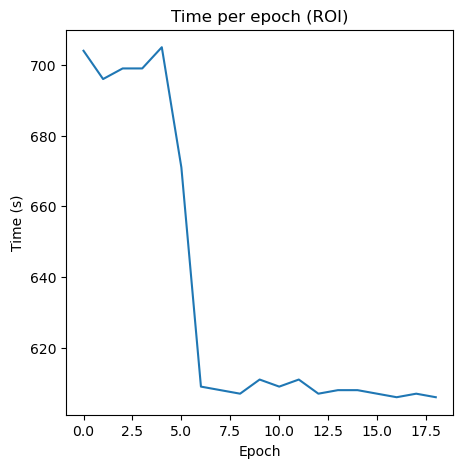

In [27]:
roi_epoch_time = [704, 696, 699, 699, 705, 671, 609, 608, 607, 611, 609, 611, 607, 608, 608, 607, 606, 607, 606]
plt.figure(figsize=(5, 5))

plt.plot(roi_epoch_time)
plt.title("Time per epoch (ROI)")
plt.ylabel('Time (s)')
plt.xlabel('Epoch')
plt.show()

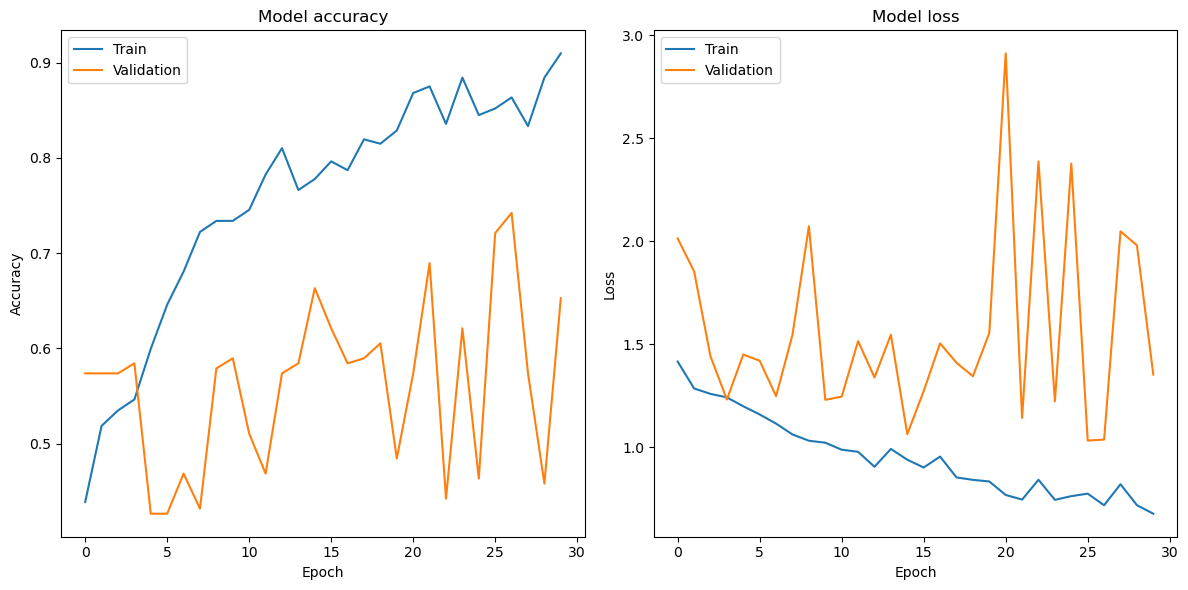

In [28]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("resnet_roi_30epoch.png")

plt.tight_layout()
plt.show()

In [29]:
from tensorflow.keras.models import load_model
md = load_model("roi_30.h5")

In [30]:
res = md.evaluate(
    test_dataset,
    steps = len(test_paths) // batch_size,
    verbose = 1
)

19/19 [==============================] - 171s 9s/step - loss: 1.3532 - accuracy: 0.6526 - recall: 0.6526 - auc: 0.7259 - precision: 0.6526


In [31]:
print(f"Testing Accuracy:{res[1]:.2f} - Loss:{res[0]:.2f} - Recall:{res[2]:.2f} - AUC:{res[3]:.2f} - Precision:{res[4]:.2f}")

Testing Accuracy:0.65 - Loss:1.35 - Recall:0.65 - AUC:0.73 - Precision:0.65


In [32]:
y_pred = md.predict(
    test_dataset,
    steps = len(test_paths) // batch_size,
    verbose = 1
)

19/19 [==============================] - 171s 10s/step


In [33]:
y_pred_arg = np.argmax(y_pred, axis=1)
y_pred_arg = y_pred_arg.tolist()

In [34]:
# y_pred_arg

In [35]:
true_labels = []
for i in range(0, len(test_paths), batch_size):
    batch_labels = test_labels[i:i + batch_size]
    true_labels.extend(batch_labels)

In [36]:
if len(y_pred) != len(true_labels):
    true_labels = true_labels[:len(y_pred)]
    
len(true_labels), len(y_pred_arg)

(190, 190)

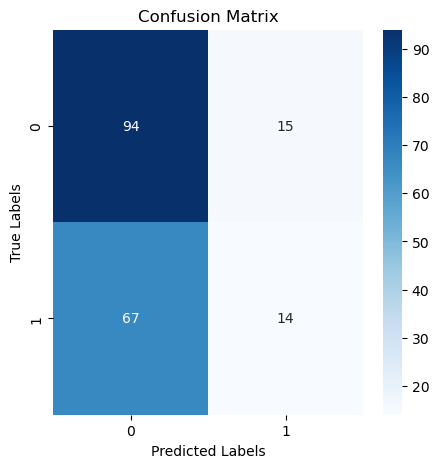

In [37]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


c_matrix = confusion_matrix(true_labels, y_pred_arg)
plt.figure(figsize=(5, 5))
sns.heatmap(c_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig("resnet_roi_30epoch_prediction.png")
plt.show()

# Non-Roi Training

In [44]:
import time
from tensorflow.keras.callbacks import Callback

class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()

In [22]:
model.load_weights("resnet18_non_roi_30.h5")

In [45]:
num_epoch = 30
nonRoi_history = model.fit(
    train_dataset,
    epochs = num_epoch,
    steps_per_epoch = len(train_paths) // batch_size,
    validation_data = test_dataset,
    validation_steps= len(test_paths) // batch_size,
    class_weight = {0:class_weights[0], 1:class_weights[1]},
    callbacks = [time_callback]
)

Epoch 1/30
44/44 [==============================] - 493s 11s/step - loss: 1.6546 - accuracy: 0.5464 - recall: 0.5464 - auc: 0.5439 - precision: 0.5464 - val_loss: 2.8072 - val_accuracy: 0.5737 - val_recall: 0.5737 - val_auc: 0.5678 - val_precision: 0.5737
Epoch 2/30
44/44 [==============================] - 487s 11s/step - loss: 1.6160 - accuracy: 0.5346 - recall: 0.5346 - auc: 0.5886 - precision: 0.5346 - val_loss: 1.7372 - val_accuracy: 0.4263 - val_recall: 0.4263 - val_auc: 0.4743 - val_precision: 0.4263
Epoch 3/30
44/44 [==============================] - 483s 11s/step - loss: 1.5522 - accuracy: 0.6308 - recall: 0.6308 - auc: 0.6715 - precision: 0.6308 - val_loss: 1.9485 - val_accuracy: 0.4263 - val_recall: 0.4263 - val_auc: 0.4650 - val_precision: 0.4263
Epoch 4/30
44/44 [==============================] - 485s 11s/step - loss: 1.5394 - accuracy: 0.5849 - recall: 0.5849 - auc: 0.6471 - precision: 0.5849 - val_loss: 2.1412 - val_accuracy: 0.4263 - val_recall: 0.4263 - val_auc: 0.4679 

In [46]:
model.save("non_roi_30.h5")

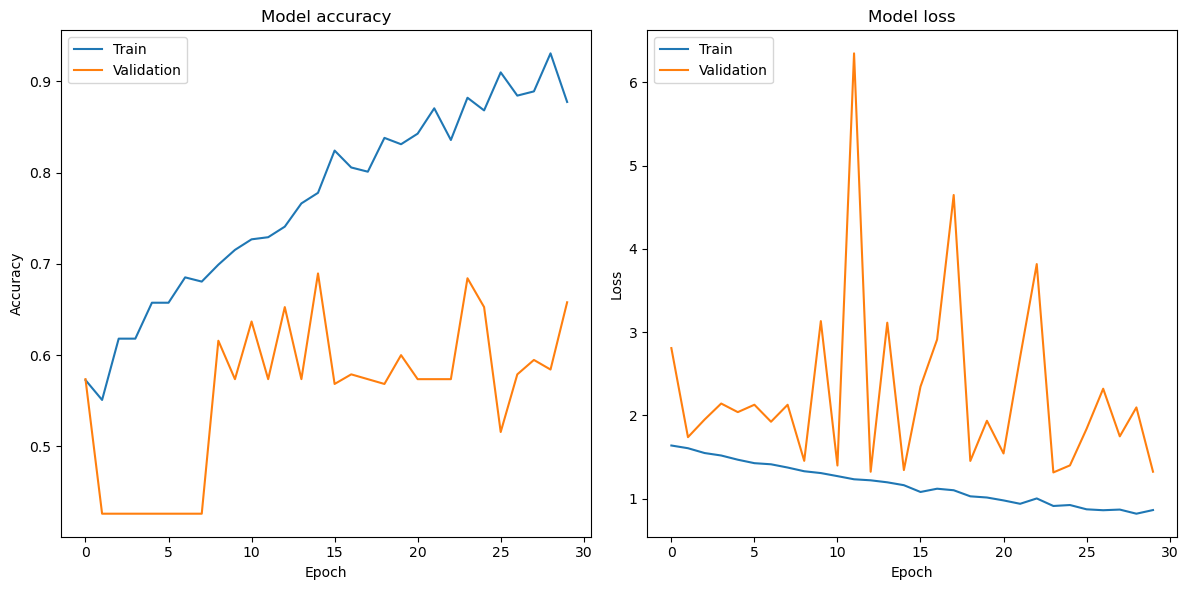

In [47]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(nonRoi_history.history['accuracy'])
plt.plot(nonRoi_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


plt.subplot(1, 2, 2)
plt.plot(nonRoi_history.history['loss'])
plt.plot(nonRoi_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("resnet_nonroi_30epoch.png")

plt.tight_layout()
plt.show()

In [49]:
from tensorflow.keras.models import load_model
nonroi_model = load_model("non_roi_30.h5")

In [50]:
res = nonroi_model.evaluate(
    test_dataset,
    steps = len(test_paths) // batch_size,
    verbose = 1
)

19/19 [==============================] - 129s 7s/step - loss: 1.3221 - accuracy: 0.6579 - recall: 0.6579 - auc: 0.7494 - precision: 0.6579


In [51]:
print(f"Testing Accuracy:{res[1]:.2f} - Loss:{res[0]:.2f} - Recall:{res[2]:.2f} - AUC:{res[3]:.2f} - Precision:{res[4]:.2f}")

Testing Accuracy:0.66 - Loss:1.32 - Recall:0.66 - AUC:0.75 - Precision:0.66


In [52]:
y_pred = nonroi_model.predict(
    test_dataset,
    steps = len(test_paths) // batch_size,
    verbose = 1
)

19/19 [==============================] - 129s 7s/step


In [53]:
y_pred_arg = np.argmax(y_pred, axis=1)
y_pred_arg = y_pred_arg.tolist()

In [54]:
true_labels = []
for i in range(0, len(test_paths), batch_size):
    batch_labels = test_labels[i:i + batch_size]
    true_labels.extend(batch_labels)

if len(y_pred) != len(true_labels):
    true_labels = true_labels[:len(y_pred)]
    
len(true_labels), len(y_pred_arg)

(190, 190)

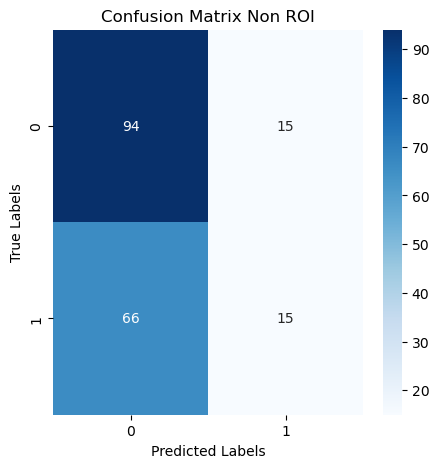

In [55]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


c_matrix = confusion_matrix(true_labels, y_pred_arg)
plt.figure(figsize=(5, 5))
sns.heatmap(c_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Non ROI')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig("resnet_non_roi_30epoch_prediction.png")
plt.show()

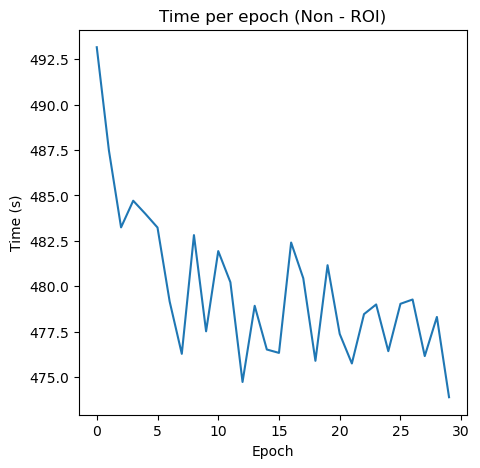

In [56]:
non_roi_epoch_times = time_callback.times

plt.figure(figsize=(5, 5))

plt.plot(non_roi_epoch_times)
plt.title("Time per epoch (Non - ROI)")
plt.ylabel('Time (s)')
plt.xlabel('Epoch')
plt.show()